<a href="https://colab.research.google.com/github/tdbartolo/tdbartolo-rep/blob/main/PNL_transformer_dataset_restaurante_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning - MVP
### Aluna: Tamara Di Bartolo

##1. Definição do Problema:
###### Análise do dataset "Restaurant Reviews in Dhaka", com o objetivo de prever a nota das avaliações de restaurantes. Para isso, foi utilizado um modelo de Deep Learning para abordar um problema de Processamento de Linguagem Natural (PLN).
######**DataSet:**https://www.kaggle.com/datasets/tuxboy/restaurant-reviews-in-dhaka-bangladesh. O dataset possui avaliações textuais de restaurantes, as notas atribuídas e uma variável booleana indicando se o restaurante é recomendado ou não. Com base nessas informações, a proposta é desenvolver um modelo que possa prever a nota de avaliação do restaurante com base nos textos das avaliações.
######**Hipótese:** Através do Fine-Tuning do Modelo BERT pré-treinado com os dados do DataSet Restaurants Reviews in Daka o modelo será capaz de prever com acurácia maior que 50% a complexa relação entre os textos das avaliações e as notas de 1 a 5 atribuídas aos restaurantes.
####Importando as bibliotecas:
######Configuração de algumas opções e importações de bibliotecas necessárias para realizar análise de dados e modelagem.


In [101]:
# instalando dependências
!pip install transformers[torch] datasets evaluate scikit-learn matplotlib #pip install dataset instala biblioteca do hugging face
!pip install gdown
from datasets import Dataset, DatasetDict
from datasets import load_dataset
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
import torch
import seaborn as sns
import gdown
import os
import zipfile
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import evaluate #biblioteca para carregar métrica


####Carga dos Dados do Treinamento Anterior Salvo no Google Drive:
######Nesta etapa, se a variável **CARGA_DADOS** for definida como **True**, os dados de treinamento do modelo BERT serão carregados no ambiente do Colab. Esses dados serão utilizados nas etapas seguintes do projeto, como o treinamento e a avaliação do modelo. Por outro lado, se a variável CARGA_DADOS for definida como **False**, o modelo BERT será treinado.

In [102]:
CARGA_DADOS = False
CARGA_DADOS_FOLDER_PATH_COLAB = "/content/modelo_bert_mvp/"
CARGA_DADOS_ZIP_NAME_COLAB = "tamara_bert_mvp.zip"
CARGA_DADOS_ZIP_URL_DRIVE = "https://drive.google.com/u/0/uc?id=1bZE6Eeh3ruVshJ8Lk5mxAJooidQH8PbT&export=download" #v_01
#CARGA_DADOS_ZIP_URL_DRIVE = "https://drive.google.com/u/0/uc?id=1v-jbgd9vzNQDhWHIFUf9Lvvl3nMpNerO&export=download" #v_02
TRAIN_MODEL_PATH = "/content/modelo_bert_mvp/tamara_bert_mvp" #onde vai salvar o modelo treinado

#Download dos dados de treinamento
if CARGA_DADOS:
  #Excluir arquivos em pasta do COLAB
  if os.path.exists(CARGA_DADOS_FOLDER_PATH_COLAB):
    shutil.rmtree(CARGA_DADOS_FOLDER_PATH_COLAB)

  url = CARGA_DADOS_ZIP_URL_DRIVE

  # Caminho completo para a nova pasta
  os.makedirs(CARGA_DADOS_FOLDER_PATH_COLAB, exist_ok=True) # cria a pasta de destino se necessário

  zip_file = CARGA_DADOS_FOLDER_PATH_COLAB + CARGA_DADOS_ZIP_NAME_COLAB # especifique o nome do arquivo e a extensão do mesmo
  gdown.download(url, zip_file)


if CARGA_DADOS:
  # Abre o arquivo ZIP
  with zipfile.ZipFile(zip_file, 'r') as zip_ref:
      # Extrai todo o conteúdo para a pasta de destino
      zip_ref.extractall(CARGA_DADOS_FOLDER_PATH_COLAB)


#### Carga do Dataset:
###### Importa do arquivo CSV do DataSet obtido no Kaggle, a partir da URL fornecida, e armazena em um dicionário chamado dataset. Foi realizada separação prévia, no arquivo CSV, dos dados do DataSet em dados de treinamento e teste. Após carregar, exibe as features e quantidade de linhas do DataSet na base de treino e teste.  

In [103]:
# carregando dados do dataset

url_test = "https://raw.githubusercontent.com/tdbartolo/tdbartolo-rep/main/test.csv"
url_train = "https://raw.githubusercontent.com/tdbartolo/tdbartolo-rep/main/train.csv"

dataset = load_dataset('csv', data_files={'train': url_train, 'test': url_test}, column_names=['text', 'label', 'Recommends'], skiprows=[0])

dataset = dataset.class_encode_column(column="label") # precisa pro trainer saber qual a coluna precisa aprender a predizer

dataset

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'Recommends'],
        num_rows: 13276
    })
    test: Dataset({
        features: ['text', 'label', 'Recommends'],
        num_rows: 3321
    })
})

## 2. Pré-processamento dos Dados
######Nesta fase crucial do projeto, realizamos o pré-processamento dos dados para garantir que estejam adequadamente preparados antes de serem utilizados no modelo de classificação de sequências com BERT. O objetivo é obter resultados mais precisos e confiáveis.

######Inicialmente, optamos por **remover a feature "Recommends"**, uma vez que ela não será utilizada na análise, simplificando assim o conjunto de dados.

######Com o intuito de garantir a qualidade dos dados, realizamos a limpeza das informações inválidas, excluindo as linhas que contêm **valores vazios ou None**. Essa etapa é fundamental para assegurar a consistência dos conjuntos de treinamento e teste.

######Em seguida, a coluna "label" foi convertida para o **tipo 'int64'**, garantindo que os rótulos das classes sejam representados por valores inteiros. Essa conversão é necessária para o correto treinamento do modelo de classificação.

######Para limpar o texto presente na coluna "text", executamos uma etapa essencial de **remoção de caracteres não-ASCII**, os quais poderiam interferir no desempenho do modelo BERT. Posteriormente, os textos foram convertidos novamente para o formato utf-8, assegurando a compatibilidade com o modelo BERT.

######Por fim, transformamos os DataFrames em formato de dicionário, utilizando a função "from_pandas", tornando-os prontos para serem utilizados como entrada no treinamento e teste do modelo de classificação de sequências com BERT. Essa preparação dos dados é um passo crucial para garantir que o modelo possa compreender e extrair informações relevantes dos textos e realizar previsões precisas.

In [104]:
dataset = dataset.remove_columns('Recommends')

# Converter o dataset para um DataFrame pandas
df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()

# Remover as linhas com valores vazios ou None
df_train = df_train.dropna()
df_test = df_test.dropna()
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_train['label'] = df_train['label'].astype('int64')
df_test['label'] = df_test['label'].astype('int64')

df_train.loc[:, "text"] = df_train["text"].str.encode("ascii", "ignore").str.decode("utf-8")
df_test.loc[:, "text"] = df_test["text"].str.encode("ascii", "ignore").str.decode("utf-8")

# Converter o DataFrame de volta para o formato de Dataset
dataset["train"] = Dataset.from_pandas(df_train)
dataset["test"] = Dataset.from_pandas(df_test)

Retorna a visualização do DataSet após o pré-processamento dos dados.

In [105]:
df_train.head(10)

,text,label
0,The man who is foodie like me for him arabian ...,4
1,This place is too much comfortable & food is d...,3
2,I check it out like a second home of mine...fe...,2
3,"you guys are awesome & I just love your ""offer...",4
4,Went there after referred by a friend. Tried t...,4
5,I went there for a family dinner . Had the set...,0
6,Everything is great..Perfect for all types of ...,2
7,Last two times we went their with some best bu...,3
8,They served tasty and good quality food,4
9,It is really a good place. Just awesome. Their...,4


#### Visualização da Base de Treino e Teste:
###### Nesta seção, são criados dois gráficos de barras lado a lado, representando a distribuição das classes nas bases de treino e teste. Cada barra corresponde a uma classe (rótulo) e a altura da barra representa a frequência dessa classe na respectiva base de dados. Essa visualização é útil para entender o balanceamento das classes nos conjuntos de treinamento e teste, o que desempenha um papel importante na avaliação de modelos de classificação.

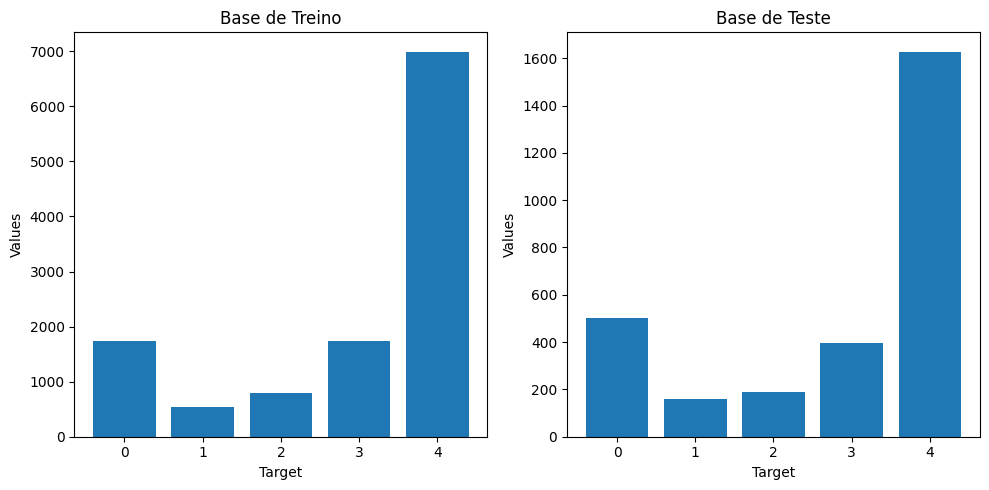

In [106]:
rat_train=df_train.label.value_counts()
rat_test=df_test.label.value_counts()

# Criação da grade de subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plotagem do primeiro gráfico
axes[0].bar(rat_train.index, rat_train.values)
axes[0].set_xticks(rat_train.index)
axes[0].set_xlabel('Target')
axes[0].set_ylabel('Values')
axes[0].set_title('Base de Treino')


# Plotagem do segundo gráfico
axes[1].bar(rat_test.index, rat_test.values)
axes[1].set_xlabel('Target')
axes[1].set_ylabel('Values')
axes[1].set_title('Base de Teste')

# Ajuste de layout e exibição dos gráficos
plt.tight_layout()
plt.show()

In [107]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11802
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2876
    })
})

 ###### Nesta etapa foram **criados DataSets menores**, representativos o suficiente para o treinamento, validação e teste do modelo, visando economizar tempo e recursos computacionais. Tal estratégia torna o processo mais eficiente, especialmente em ambientes com limitações de recursos como o Colab.
 ###### Devido ao modelo BERT ser um modelo bastante complexo, com um grande número de parâmetros a serem ajustados **optou-se por não utilizar a validação cruzada** o que poderia aumentar ainda mais a complexidade, tornando o treinamento e a avaliação do modelo mais difíceis e demorados.


In [108]:
# gerando datasets menores para treino, validação e teste (para poupar tempo)
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(1000)) # embaralha os dados do Dataset train e pega as linhas de 0 a 999 para o treino
small_dev_dataset = dataset["train"].shuffle(seed=42).select(range(1000,1500)) # embaralha os dados do Dataset train e pega os dados de 1.000 a 1.499 para validação
small_test_dataset = dataset["test"].shuffle(seed=42).select(range(500)) #embaralha os dados do Dataset test e pega as linhas de 0 a 500 do teste

## 3. Modelagem e treinamento:
######Nesta seção, verifica-se a variável CARGA_DADOS para determinar se o modelo BERT pré-treinado e o tokenizer, necessário para processar os textos, devem ser carregados a partir de um **modelo previamente treinado armazenado no ambiente de execução** (**CARGA_DADOS=TRUE**) ou se devem ser carregados a partir do **modelo pré-treinado padrão disponível online** (**CARGA_DADOS=FALSE**) e posteriormente treinado com este DataSet.
######**Definição do modelo:** O **BERT** (Bidirectional Encoder Representations from Transformers) é um modelo de linguagem desenvolvido pelo Google que revolucionou o processamento de linguagem natural (NLP). Ele é baseado na arquitetura de rede neural chamada Transformer, que é projetada para capturar relações de dependência em sequências de dados, como texto. Uma das principais características do BERT é sua capacidade de entender o contexto das palavras em uma frase ou texto. Ao contrário de modelos anteriores, que consideravam apenas as palavras à esquerda ou à direita de uma palavra para tentar prever essa palavra, o BERT usa um mecanismo bidirecional. Ele processa as palavras em ambos os sentidos, capturando o contexto global de toda a sequência. Isso permite que o BERT compreenda melhor as relações entre as palavras e, consequentemente, produza representações mais ricas e precisas do texto. O modelo utilizado é adequado para o problema de classificação de texto categórico com 5 classes, que envolve a avaliação de restaurantes com notas de 1 a 5.

In [109]:
if CARGA_DADOS:
  #carrega o nosso modelo que salvamos no ambiente de execução do colab
  model = AutoModelForSequenceClassification.from_pretrained(CARGA_DADOS_FOLDER_PATH_COLAB)
  tokenizer = AutoTokenizer.from_pretrained(CARGA_DADOS_FOLDER_PATH_COLAB)
else:
  #carregando modelo BERT pré-treinado e o tokenizer do modelo pré-treinado
  model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)
  tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Tokenizer:
###### **O tokenizer** é responsável por pré-processar os textos brutos para torná-los adequados ao modelo de linguagem BERT. Ele divide o texto em tokens individuais, que podem ser palavras ou subpalavras, convertendo-os em representações numéricas. Além disso, o tokenizer adiciona padding aos textos para que todos tenham o mesmo comprimento, assegurando que o modelo funcione com lotes de dados de tamanho fixo. Se um texto for mais longo que o comprimento máximo permitido, ele é truncado para se ajustar ao tamanho especificado. Por fim, cada token é convertido em um ID numérico correspondente no vocabulário do modelo, transformando o texto original em uma sequência de IDs pronta para ser processada pelo modelo. Na sequência foram impressos no formato Dataset os ID criados pelo tokenizador.

In [110]:
#chama a função tokenized e aplica em cada linha do texto
#método map passa uma função em todo o dataset
#o toquenizador criou input_ids', 'token_type_ids', 'attention_mask'
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_small_train_dataset = small_train_dataset.map(tokenize_function, batched=True)
tokenized_small_dev_dataset = small_dev_dataset.map(tokenize_function, batched=True)
#tokenized_small_test_dataset = small_test_dataset.map(tokenize_function, batched=True)

#visualização do dataset
small_train_df = pd.DataFrame(tokenized_small_train_dataset)
small_train_df.head(10)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

,text,label,input_ids,token_type_ids,attention_mask
0,Chicken chap and luchi... Awsm taste...with an...,4,"[101, 18770, 22572, 11478, 1105, 181, 16643, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,One of my favourite..I just loved the decorati...,4,"[101, 1448, 1104, 1139, 9122, 119, 119, 146, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"Undoubtedly,one of the best place for pizza,pa...",4,"[101, 12118, 2572, 10354, 1906, 1193, 117, 114...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,Taste of the foods were phenomenal the steak w...,4,"[101, 27589, 1104, 1103, 11785, 1127, 14343, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,Hidden camera in girls washroom. Everyone boyc...,0,"[101, 19595, 4504, 1107, 2636, 10124, 6077, 11...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
5,", , ? , , ...",1,"[101, 117, 117, 136, 117, 117, 117, 119, 119, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
6,"Average,, not good at all..quantity and qualit...",2,"[101, 18098, 117, 117, 1136, 1363, 1120, 1155,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7,It's wallah and delicious... Keep up this fabu...,3,"[101, 1135, 112, 188, 2095, 3354, 1105, 13108,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
8,osmmmm place & also osmmm food I loved it ...,4,"[101, 184, 6602, 6262, 1306, 1282, 111, 1145, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9,"Classy & delicious food menu , elegant space t...",4,"[101, 3699, 1183, 111, 13108, 2094, 13171, 117...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


#### Configuração do Treinamento:
######Nesta etapa, o código está **configurando o treinamento** de um modelo de classificação de texto usando o **BERT** (Bidirectional Encoder Representations from Transformers).
######O código começa definindo a métrica que será usada para avaliar o desempenho do modelo, nesse caso, a métrica é a **acurácia**, que mede a proporção de previsões corretas em relação ao total de previsões.
######O objeto **"training_args"** é criado para definir os argumentos de treinamento do modelo. Ele especifica configurações como o diretório onde os modelos treinados serão salvos, o intervalo de avaliação, o tamanho do lote (batch size), a taxa de aprendizado, entre outros parâmetros importantes para o treinamento.
######O objeto **"trainer"** é criado para realizar o treinamento propriamente dito. Ele contém todas as informações necessárias para executar o treinamento, monitorar o progresso, salvar checkpoints e realizar avaliações periódicas usando os datasets de treinamento e avaliação fornecidos. O modelo utilizado é o BERT previamente carregado, e os dados de treinamento e avaliação são fornecidos na forma de datasets tokenizados.
######**Otimização dos Hiperparâmetros:** Foram experimentadas variações dos hiperparametros abaixo e os valores mantidos no modelo foram os que apresentaram melhores resultados.
######Experimentei variações dos parametros abaixo para acelerar a execução durante os treinamentos e verificar se prejudicava a acurácia, acabei voltando para valores originais para não prejudicar a acertividade do modelo.
**Learning_rate:** diferentes valores de taxa de aprendizado, 3e-5, 1e-5 ou 5e-5. Ficamos com 3e-5 que apresentou boa performance e ajudou o modelo a convergir para uma solução mais precisa.

**Max_steps:** Aumentei e diminui o número máximo de etapas de treinamento para ajustar o tempo e a profundidade do treinamento.
**Per_device_train_batch_size:** Experimentei diferentes tamanhos de lote para otimizar o uso da memória da GPU e o tempo de treinamento.
**Gradient_accumulation_steps:** Ajuste o número de passos de acúmulo de gradiente para otimizar o uso da memória da GPU.


In [111]:
metric = evaluate.load("accuracy")

#cria uma função para computar a métrica
def compute_metrics(eval_pred): #eval_pred é o que o modelo previu
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1) #pega o id que tem maior probabilidade
    return metric.compute(predictions=predictions, references=labels) #compara o ID predito com o label esperado

training_args = TrainingArguments(
    output_dir=TRAIN_MODEL_PATH,       #Define o diretório onde os modelos treinados serão salvos.
    evaluation_strategy="steps",       #Avaliação realizada a cada 10 steps
    eval_steps=10,                     #Especifica o intervalo em que as avaliações serão realizadas.
    per_device_train_batch_size=8,     #Definem o tamanho do lote (batch size) para treinamento e avaliação em cada dispositivo
    per_device_eval_batch_size=8,      #Definem o tamanho do lote (batch size) para treinamento e avaliação em cada dispositivo
    gradient_accumulation_steps=4,     #Define quantos passos de acúmulo de gradiente são realizados antes de atualizar os parâmetros do modelo.
    max_steps=200,                     #Define o número máximo de etapas (steps) de treinamento que serão realizadas.
    learning_rate=3e-5,                #Taxa de aprendizado utilizada no treinamento do modelo.
    logging_strategy="steps",          #Controla a exibição do log de treinamento.
    logging_steps=10,                  #Controla a exibição do log de treinamento.
    save_steps=50,                     #salvar check point a cada 50 steps
    load_best_model_at_end=True,       #pega o melhor dos que salvou
    metric_for_best_model="accuracy",  #A métrica que será usada para selecionar o melhor modelo.
    greater_is_better=True,            #Define se valores maiores da métrica são melhores (verdadeiro)
    save_total_limit=2,                #Define o número máximo de checkpoints que serão salvos.
    disable_tqdm=False                 #Exibe a barra de progresso do treinamento
)

#O objeto trainer criado contém todas as informações necessárias para realizar o treinamento do modelo de
#classificação de texto usando o BERT. Ele irá executar o treinamento, monitorar o progresso, salvar checkpoints
#e realizar avaliações periódicas usando os datasets de treinamento e avaliação fornecidos.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_small_train_dataset,
    eval_dataset=tokenized_small_dev_dataset,
    compute_metrics=compute_metrics,
)

#### Treinamento:
Quando a variável **"CARGA_DADOS" for False, o modelo BERT será treinado** utilizando as configurações e os dados fornecidos no objeto "trainer". O objeto "trainer" contém todas as informações necessárias para realizar o treinamento do modelo de classificação de texto utilizando o BERT. Essas informações incluem o modelo pré-treinado, os argumentos de treinamento, os datasets de treinamento e avaliação, e a função para computar as métricas de avaliação. Durante o treinamento, o modelo BERT pré-treinado é ajustado (**fine-tuned**) com os dados do conjunto de treinamento específico para essa tarefa. Essa etapa visa permitir que o modelo aprenda e compreenda a complexa relação entre os textos das avaliações e as notas atribuídas aos restaurantes.

In [112]:
if not CARGA_DADOS:
  trainer.train() #treina o modelo

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
10,1.285500,1.220986,0.574000
20,1.213100,1.121324,0.574000
30,1.073900,1.005141,0.602000
40,0.884400,0.951752,0.698000
50,0.785800,0.926923,0.694000
60,0.924900,0.855199,0.698000
70,0.656100,0.842161,0.712000
80,0.694600,0.852013,0.700000
90,0.759300,0.857020,0.694000
100,0.603600,0.840940,0.696000


## 4. Avaliação dos Resultados:
###### Nesta etapa de Avaliação dos Resultados, apresentamos três subplots lado a lado, cada um exibindo curvas distintas do modelo BERT durante o processo de treinamento. Cada subplot é dedicado a uma curva específica, com o eixo x representando o "Passo de Treinamento" e o eixo y representando a **Acurácia**, **Perda de Avaliação (eval_loss)** e **Perda de Treinamento (loss)**.
######Essas curvas são fundamentais para compreender o comportamento do modelo ao longo do treinamento. A curva de acurácia mostra o desempenho do modelo em cada passo do treinamento, indicando a taxa de previsões corretas em relação ao total de previsões. A curva de perda de avaliação reflete a variação da perda calculada em um conjunto de dados de avaliação, mostrando como o modelo se ajusta e aprende com os dados desconhecidos. Já a curva de perda de treinamento retrata a evolução da perda medida durante o treinamento, fornecendo insights sobre a otimização do modelo ao longo do processo.
###### Com base nos gráficos, pôde-se verificar que o modelo aprendeu bem a complexa relação entre os textos das avaliações e as notas atribuídas aos restaurantes pois a acurácia aumenta e a perda diminui ao longo do treinamento.

In [113]:
#verifica se loss está muito ruidoso (sobe e desce) que o learning rate pode estar muito alto ou o dado estar ruim
if CARGA_DADOS:
  HISTORICO_PATH = CARGA_DADOS_FOLDER_PATH_COLAB + "historico_treinamento.csv"
  df_log = pd.read_csv(HISTORICO_PATH)
else:
  #Salva os dados do historico do treinamento em arquivo CSV
  df_log = pd.DataFrame(trainer.state.log_history)
  HISTORICO_PATH = TRAIN_MODEL_PATH + "/historico_treinamento.csv"
  df_log.to_csv(HISTORICO_PATH, index=False)
  #salva o modelo e o tokenizador
  trainer.save_model(TRAIN_MODEL_PATH)
  tokenizer.save_pretrained(TRAIN_MODEL_PATH)


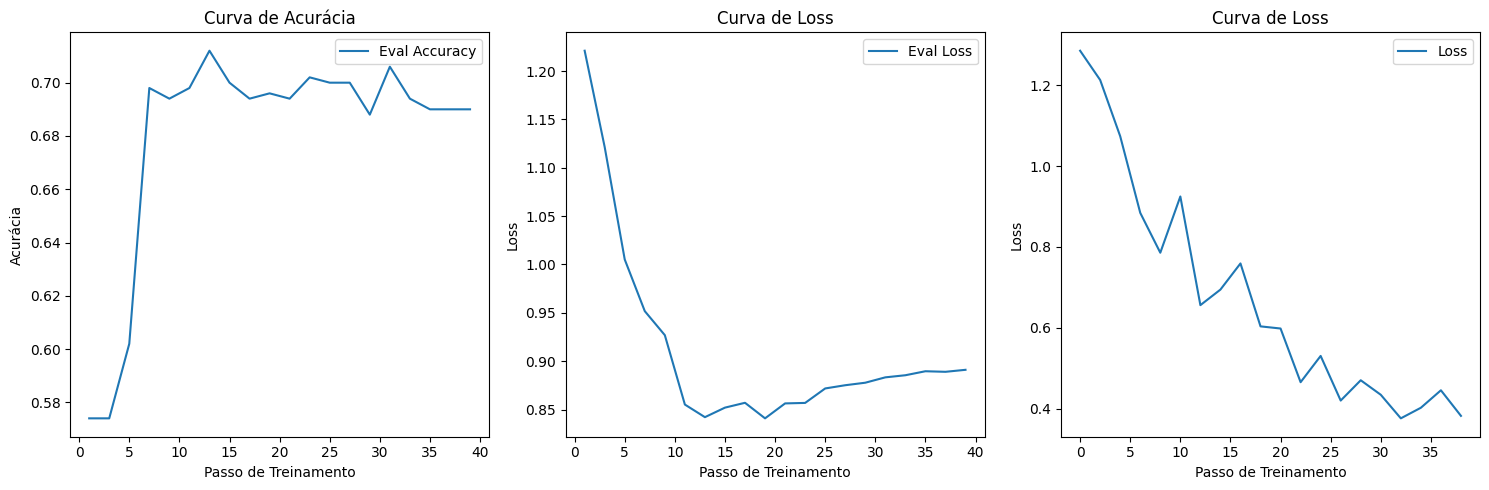

In [114]:
# Criar uma figura e eixos para os subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plotar a curva de eval_accuracy
axes[0].plot(df_log["eval_accuracy"].dropna())
axes[0].set_xlabel('Passo de Treinamento')
axes[0].set_ylabel('Acurácia')
axes[0].set_title('Curva de Acurácia')

# Plotar a curva de eval_loss
axes[1].plot(df_log["eval_loss"].dropna())
axes[1].set_xlabel('Passo de Treinamento')
axes[1].set_ylabel('Loss')
axes[1].set_title('Curva de Loss')

# Plotar a curva de loss
axes[2].plot(df_log["loss"].dropna())
axes[2].set_xlabel('Passo de Treinamento')
axes[2].set_ylabel('Loss')
axes[2].set_title('Curva de Loss')

# Adicionar legendas
axes[0].legend(["Eval Accuracy"])
axes[1].legend(["Eval Loss"])
axes[2].legend(["Loss"])

# Ajustar o espaçamento entre os subplots
plt.tight_layout()

# Exibir os gráficos lado a lado
plt.show()

## Outros

In [115]:
small_test_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 500
})

#### Avaliação do Modelo nos Dados de Teste:
######Este código realiza a **avaliação do modelo** de classificação treinado utilizando o BERT no **conjunto de dados de teste**. Essa etapa é crucial para verificar o quão bem o modelo generaliza para novos dados e como ele se comporta em situações reais.
######A **métrica** utilizada para avaliar o modelo é a **acurácia**, uma medida comum em problemas de classificação. A acurácia representa a proporção de previsões corretas que o modelo fez em relação ao número total de previsões no conjunto de teste. Em outras palavras, ela nos mostra a taxa de acertos do modelo.

In [116]:
# Criar uma lista para armazenar as predições
predictions = []
real = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Iterar sobre as amostras do dataset
for example in small_test_dataset:
    # Tokenizar o texto
    encoded_input = tokenizer(example["text"], return_tensors="pt")

    # Mover os dados para o mesmo dispositivo (CPU ou GPU) do modelo
    encoded_input = {key: tensor.to(device) for key, tensor in encoded_input.items()}

    # Passar os dados tokenizados pelo modelo
    output = model(**encoded_input)
    probs = torch.softmax(output.logits, dim=1)
    pred = torch.argmax(probs, dim=1).item()
    #print(probs)
    # Armazenar a predição na lista de predições
    predictions.append(pred)
    real.append(example["label"])

# Imprimir as predições
accuracy = accuracy_score(real, predictions)
print(f"Acurácia: {accuracy}")
#print(predictions)
#print(real)

Acurácia: 0.678


####Matriz de Confusão:
######Por fim, foram utilizadas as bibliotecas sklearn.metrics, matplotlib e seaborn para calcular a matriz de confusão e gerar um heatmap a partir dos resultados obtidos pelo modelo de classificação. O resultado final do heatmap permite visualizar de forma clara e intuitiva a distribuição das classificações corretas e incorretas do modelo para cada classe, auxiliando na análise do desempenho do modelo e na identificação de possíveis padrões ou erros de classificação. Cada célula do heatmap representa a contagem ou proporção de previsões corretas ou incorretas para cada combinação de classes de saída (verdadeiro) e classes previstas pelo modelo (predição). As cores mais escuras indicam uma contagem maior, que confirmam os resultados obtidos acurácia do modelo.

Text(50.722222222222214, 0.5, 'Truth')

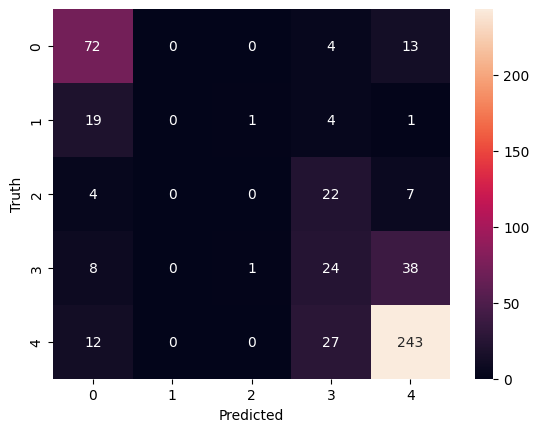

In [117]:
cm=confusion_matrix(real,predictions)
sns.heatmap(cm,annot=True,fmt='d')

plt.xlabel("Predicted")
plt.ylabel("Truth")